<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/IAP_T2_E2_JJTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Introducción al Aprendizaje Profundo
# José de Jesús Tapia López
# Tarea 2: Redes Convolucionales
# 11 de Mayo de 2021

## Ejercicio 2

Extiende la libreta **2b_comida_inception.ipynb** para implementar y entrenar la arquitectura tipo ResNet que se especifica en la figura que viene en el PDF de la tarea.

## 1. Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1. Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image

### 1.2. Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = '../datos/recipes'
filename = 'recipes2k.tar.gz'
data_dir = '../datos/recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## 2. Datos

### 2.1. Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_pipeline.png"/>

### 2.2. Descarga de Recipes2k

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../datos/recipes/recipes2k.tar.gz’ already there; not retrieving.


### 2.3. Conjunto de datos

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'trn.csv'), index_col='item')
df.head()

,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
item,,,,,,,,,,
apple_pie,0,0,1,0,0,0,1,0,1,0
baby_back_ribs,0,0,0,0,1,0,0,1,1,1
beef_tacos,0,0,0,0,1,0,1,1,1,1
beet_salad,1,0,0,0,1,0,0,1,0,0
bread_pudding,0,0,1,0,0,0,1,0,1,0


In [6]:
! ls {data_dir}/trn/beet_salad | head -5

0_maple_roasted_beet_and_goat_cheese_salad.jpg
10_balsamic_beet_salad_with_arugula_and_goat_cheese.jpg
11_roasted_beet_and_goat_cheese_salad.jpg
12_cathys_bodacious_beet_salad.jpg
13_red_beet_salad.jpg


In [7]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4. Exploración

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


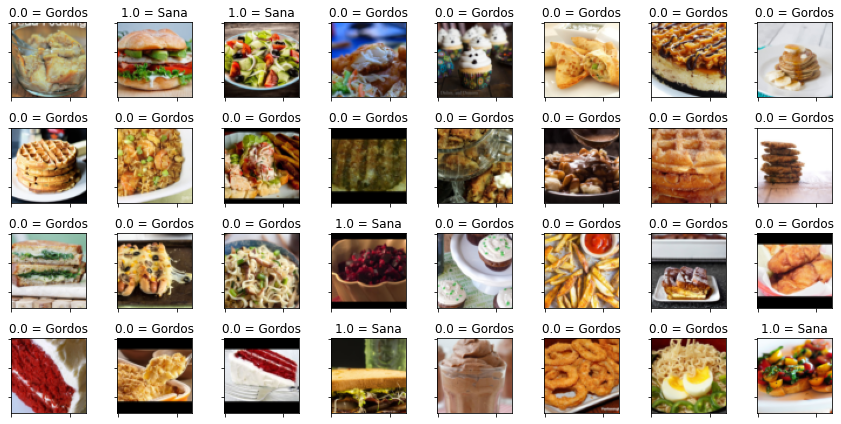

In [8]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.3 Cargador de datos

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


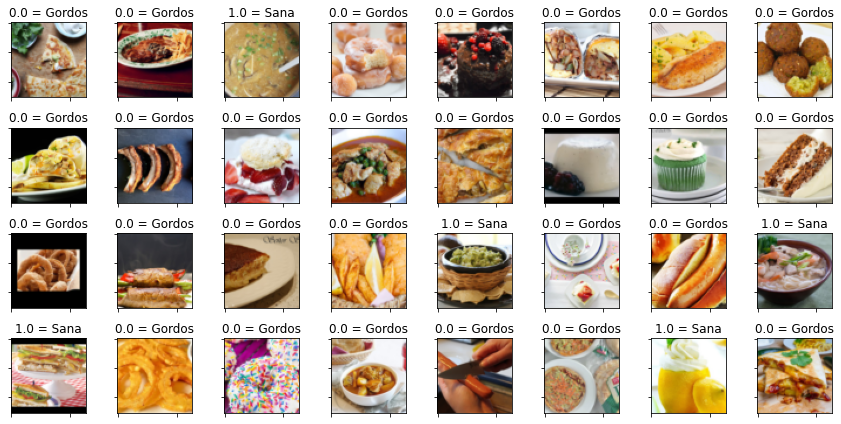

In [9]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3. Arquitectura

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1. Definición del bloque que viene especificado en la tarea

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/photo4940952282107849034.jpg" width="700"/>


In [10]:
class ResNet2(nn.Module):
 
    def __init__(self, in_channels, out_channels):
        super(ResNet2, self).__init__()
        out_channels1, out_channels2 = out_channels
 
        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_branch1 = nn.Sequential(
            # PRIMERA CONV
            # [N, I, H, W] => [N, O1, H, W]
            # kernel_size=3, stride= 1, padding=1
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, stride=1, padding=1),
            # BatchNorm
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # ReLU
            # [N, O1, H, W]
            nn.ReLU(),
            
            # SEGUNDA CONV
            # [N, O1, H, W] => [N, O2, H, W]
            # kernel_size=3, stride= 1, padding=1
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, stride=1, padding=1),
            # BatchNorm
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # ReLU
            # [N, O2, H, W]
            nn.ReLU(),
        )
        
        # [N, I, H, W] => [N, O2, H, W]
        # kernel_size=1, stride= 1, padding=0
        self.cnn_branch2 = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=out_channels2, 
                                 kernel_size=1, stride=1, padding=0)
 
    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_branch1(x)
        # [N, I, H, W] => [N, O2, H, W]
        x2 = self.cnn_branch2(x)
        # sumamos (acorde al bloque)
        # [N, O2, H, W]
        x = x1 + x2
        return x

Creemos un modelo:

In [11]:
block = ResNet2(in_channels=3, out_channels=(3, 3))
block

ResNet2(
  (cnn_branch1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (cnn_branch2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

Probemos con datos sintéticos:

In [12]:
x = torch.zeros(1, 3, 64, 64)
y = block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 3, 64, 64])


Inspeccionemos:

In [13]:
summary(block, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet2                                  --                        --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-2                  [1, 3, 64, 64]            6
│    └─ReLU: 2-3                         [1, 3, 64, 64]            --
│    └─Conv2d: 2-4                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-5                  [1, 3, 64, 64]            6
│    └─ReLU: 2-6                         [1, 3, 64, 64]            --
├─Conv2d: 1-2                            [1, 3, 64, 64]            12
Total params: 192
Trainable params: 192
Non-trainable params: 0
Total mult-adds (M): 0.70
Input size (MB): 0.05
Forward/backward pass size (MB): 0.49
Params size (MB): 0.00
Estimated Total Size (MB): 0.54

### 3.2. Definición de arquitectura 

<img src="https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/master/Figuras/T2/photo4940952282107849035.jpg" width="350"/>

In [14]:
class MicroResNet2(nn.Module):

    def __init__(self):
        super(MicroResNet2, self).__init__()
        self.num_feats = 3 * 16 * 16
        
        # [N, 3, 64, 64] => [N, 3, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 64, 64] => [N, 3, 64, 64]
            ResNet2(in_channels=3, out_channels=(3, 3)),
            # [N, 3, 64, 64] => [N, 3, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 3, 32, 32] => [N, 3, 32, 32]
            ResNet2(in_channels=3, out_channels=(3, 3)),
            # [N, 3, 32, 32] => [N, 3, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # [N, 3, 16, 16] => [N, 3x16x16]
        self.flatten = nn.Flatten()

        # [N, 3x16x16] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 16, 16]
        x = self.cnn(x)
        # [N, 3, 16, 16] => [N, 3x16x16]
        x = self.flatten(x)
        # [N, 3x16x16] => [N, 1]
        x = self.cls(x)
        return x

Creemos un modelo:

In [15]:
model = MicroResNet2()
model

MicroResNet2(
  (cnn): Sequential(
    (0): ResNet2(
      (cnn_branch1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (cnn_branch2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResNet2(
      (cnn_branch1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1,

Probemos con datos sintéticos:

In [16]:
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 1])


Inspeccionemos:

In [17]:
summary(model, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
MicroResNet2                             --                        --
├─Sequential: 1-1                        [1, 3, 16, 16]            --
│    └─ResNet2: 2-1                      [1, 3, 64, 64]            --
│    │    └─Sequential: 3-1              [1, 3, 64, 64]            180
│    │    └─Conv2d: 3-2                  [1, 3, 64, 64]            12
│    └─MaxPool2d: 2-2                    [1, 3, 32, 32]            --
│    └─ResNet2: 2-3                      [1, 3, 32, 32]            --
│    │    └─Sequential: 3-3              [1, 3, 32, 32]            180
│    │    └─Conv2d: 3-4                  [1, 3, 32, 32]            12
│    └─MaxPool2d: 2-4                    [1, 3, 16, 16]            --
├─Flatten: 1-2                           [1, 768]                  --
├─Linear: 1-3                            [1, 1]                    769
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-add

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650"> -->

In [18]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-1, epochs=15,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

Entrenemos nuestro modelo:

In [20]:
model = MicroResNet2()
loss_hist, acc_hist = train(model, trn_dl,epochs=10)

E00 loss= 51.94 acc=78.38
E01 loss= 54.27 acc=78.28
E02 loss= 45.69 acc=80.09
E03 loss= 45.42 acc=80.27
E04 loss= 43.85 acc=81.11
E05 loss= 44.50 acc=79.91
E06 loss= 45.74 acc=80.53
E07 loss= 43.62 acc=81.22
E08 loss= 43.90 acc=80.97
E09 loss= 40.31 acc=82.82



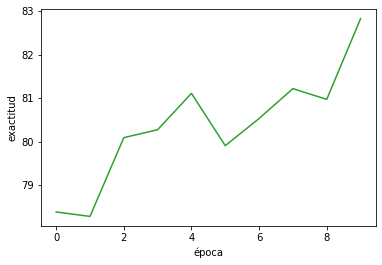

In [21]:
plt.plot(acc_hist, 'tab:green')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

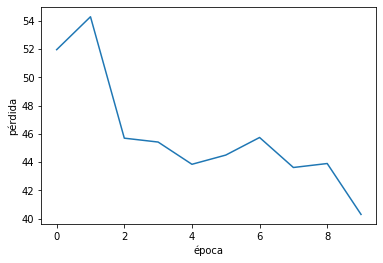

In [22]:
plt.plot(loss_hist, 'tab:blue')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

## 5. Probando con vitamina T

In [23]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(data_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

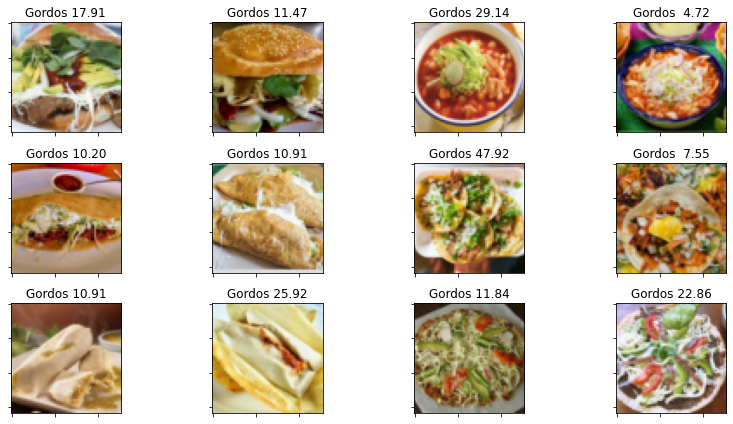

In [24]:
# desplegamos con probas
titles = []
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        prob = torch.sigmoid(model(img_torch))
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}')
        else:
            titles.append(f'Sana {prob:5.2f}')

display_grid(imgs, titles, 3, 4)

Parece ser que este modelo es bueno. Las comidas poco saludables las identifica como corresponden: NO SANAS.


